In [1]:
from pathlib import Path
import os, sys
import geopandas as gpd
import pandas as pd
import math
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from drone_detector.utils import *
from drone_detector.processing.tiling import *

In [2]:
def get_len(geom):
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return max(edge_len)

def get_diam(geom):
    mrr = geom.minimum_rotated_rectangle
    x, y = mrr.exterior.coords.xy
    edge_len = (Point(x[0], y[0]).distance(Point(x[1], y[1])), Point(x[1], y[1]).distance(Point(x[2], y[2])))
    return min(edge_len)

# Introduction

Deadwood and decaying wood, both standing and fallen, is a vital component for the biodiversity of forests, as it offers a home for several endangered species (such as fungi, mosses, insects and birds). However, when comparing European countries, Finland ranks on the bottom in the amount of both standing and fallen deadwood (m³/ha), with on average only 6 m³/ha of both deadwood types. There are, however, large differences between different forest types, as non-managed old-growth forests have several times more deadwood compared to managed forests.

[Kattenborn2019](http://dx.doi.org/10.1016/j.rse.2019.03.025) propose that UAVs are in some cases an efficient alternative for traditional field sampling. For instance, if the goal is to estimate spatial coverage of a single species, utilizing plot-based or point-based field sampling data has several challenges, such as spatial inaccuracies and limited spatial coverage. Moreover, acquiring field data is labour intensive and costly. UAVs, on the other hand, provide continuous, georeferenced field data in larger quantities than field sampling. Because these data have very high spatial resolution, it is possible for experts to visually identify the target of interest. Of course, this type of ground reference data has its limitations, as it is only possible to identify objects that are visible from the data, and if the target is to estimate e.g. growing stock volume or basal area, field work is then needed. 

To the best of our knowledge, there are no previous work about deadwood detection, standing or fallen, from UAV images using state-of-the-art object detection models. This work aims to produce a tool that can be used to generate deadwood tree species map automatically and accurately from captured RGB imagery. We will also address the shortcomings for deadwood mapping using only UAV imagery.

# Materials and methods

## Study area

The study area is located in the eastern side of Hiidenportti National Park, Eastern-Finland, and the field data contains areas both inside and outside the conserved areas (Hiidenportti National Park in the west and Teerisuo - Lososuo area in the east). The most common trees in Hiidenportti area are Scots pine and Norway spruce, with different deciduous trees (e.g. Silver birch, Downy birch and European aspen). 

The nine partially overlapping UAV orthoimages cover approximately 10 km² area, with spatial resolution ranging between 3.9cm and 4.4cm. These scenes cover both conserved and managed forests, as well as some logging openings. The UAV data were collected on 16. and 17.7.2019 using DJI Phantom 4 RTK UAV equipped with 20 megapixel CMOS sensor. 

Our other study area is located in Sudenpesänkangas, Evo, Southern-Finland. The data was acquired on 11.7.2018, and it has a spatial resolution of 4.9cm. The area covers both managed and conserved areas, and the canopy is mostly dominated by Scots pine and Norway spruce, with a mixture of the two birch species. Other species (e.g. aspen and larch) are rather scarce in dominant canopy layer. Data from Evo was used only to test the transferability of the models.

## Virtual deadwood data

Having accurate and good quality ground reference data is not only important for training the models, but also for evaluating the obtained results. Even though we had extensive field data from both of our study areas, using only these data would not provide enough training or validation data for our methods. In Hiidenportti area, out of the 178 circular field plots with 9m radius, our UAV data covered 75 in such way that the image quality was sufficient for our study. Out of these 75, we omitted four plots as they had been cut down between the time of field work and UAV flights, bringing the total number of field plots to 71. 23 of these field plots contained accurately measured and located deadwood data, collected by [Heinaro2021](https://www.sciencedirect.com/science/article/pii/S0378112721003133). In Evo area, the UAV data covered 79 circular field plots with 9 meter radius, from which 71 had suitable image quality for our use case. 

### Hiidenportti dataset

Because we had accurately measured deadwood data from Hiidenportti, we decided to use it as the training data for our deadwood models. In order to have enough training data, we constructed 33 rectangular virtual plots in such way that all usable field plots were covered and each plot had at least 45 meter distance to the border of the virtual plot. This was done to provide our method with rectangular data, and to ensure that same areas were not present in multiple virtual plots. These virtual plots contained between 1 and 7 field plots, and the area covered by a single virtual plot ranged from 8100 m² to 55032 m². From these data, human annotators manually digitized more than 8000 deadwood instances, both standing and fallen, from the UAV images. Each visible chunk was annotated as a separate instance.

In [3]:
full_data = gpd.read_file('../../data/raw/hiidenportti/virtual_plots/all_deadwood_hiidenportti.geojson')

In total, the final deadwood data contained 7396 annotated fallen deadwood and 1083 standing deadwood instances. The total numbers of deadwood instances present in a single virtual plot varied between 47 and 1051, the number of fallen deadwood between 31 and 990, and for the number of standing deadwood between 1 and 159. Relatively, standing deadwood was much more common in conserved areas than in managed forests, as 59% (639 instances) of standing deadwood were located in conservation areas, compared to 30.6% (2260 instances) of fallen deadwood. 

In [4]:
pd.crosstab(full_data.conservation, full_data.layer, margins=True)

layer,groundwood,uprightwood,All
conservation,,,
0,5136,444,5580
1,2260,639,2899
All,7396,1083,8479


In addition to the total number of deadwood instances, these data tells us also the total area covered in m² as well as pixels for each deadwood type, both for the polygons and their bounding boxes. In addition, we estimated the trunk length of the fallen deadwood and the maximum canopy diameter of the standing deadwood to be the longer side of the minimum rotated rectangle for the corresponding polygon. Because the spatial resolution of our data is around 4cm, we did not estimate fallen deadwood diameter or volume, as even an error of one pixel effects these calculations too much. 

Overall, the total area covered by fallen deadwood was 3459.81m² and 3565.37m² by standing deadwood. The mean area covered by a single fallen deadwood polygon was around 0.47m² and 3.29m² for standing deadwood. 

In [5]:
full_data['area'] = full_data.geometry.area
full_data['pixel_area'] = full_data.area / 0.04**2

In [6]:
full_data_dis = full_data.dissolve(by='layer')
full_data_dis.area

layer
groundwood     3459.805448
uprightwood    3565.369704
dtype: float64

In [7]:
pd.pivot_table(full_data, index=['layer'], values='area', aggfunc=['min', 'max', 'mean', 'median'], margins=True)

,min,max,mean,median
,area,area,area,area
layer,,,,
groundwood,0.024711,5.789380,0.469012,0.348866
uprightwood,0.103820,24.334151,3.292461,2.416391
All,0.024711,24.334151,0.829644,0.395097


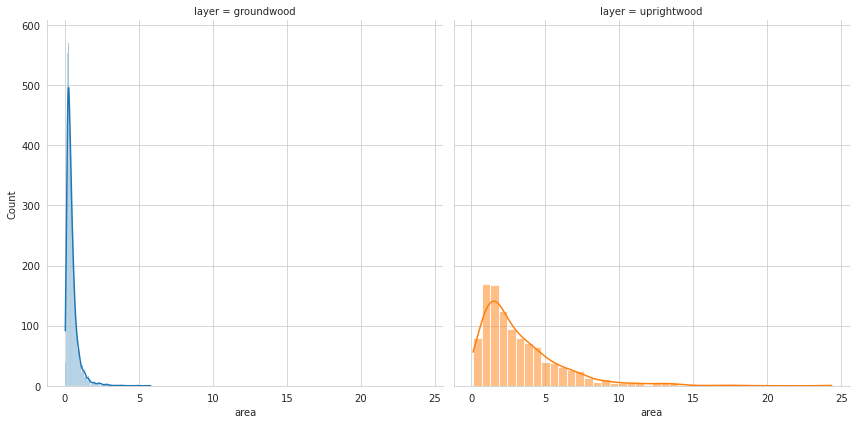

In [8]:
g = sns.FacetGrid(full_data, col='layer', height=6, hue='layer')
g.map(sns.histplot, 'area', kde=True, stat='count')

The average fallen deadwood trunk length was around 2.48 meters, with the shortest annotated tree being 0.21m and longest 15.38m. On average, both deadwood types were larger in the conservation areas compared to the managed forests. It is worth mentioning that 1655 of the annotated fallen deadwood were shorter than 1.3m (the minimum length for the tree to be measured in the Finnish National Forest Inventory), but due to the possibility of them being partially obscured by the canopy, they were included in the deadwood data. 

In [9]:
full_data['tree_length'] = full_data.apply(lambda row: get_len(row.geometry), axis=1)

In [10]:
len(full_data[(full_data.layer == 'groundwood') & (full_data.tree_length < 1.3)])

1655

In [11]:
full_data[full_data.layer=='uprightwood'].tree_length.describe()

count    1083.000000
mean        2.323786
std         1.006566
min         0.385542
25%         1.604462
50%         2.154042
75%         2.900559
max         8.313442
Name: tree_length, dtype: float64

In [12]:
pd.pivot_table(full_data, index=['conservation', 'layer'], 
               values=['tree_length'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

min         max        mean      median  \
                         tree_length tree_length tree_length tree_length   
conservation layer                                                         
0            groundwood     0.261468   15.383351    2.234979    1.880893   
             uprightwood    0.385542    6.977358    2.282999    2.112845   
1            groundwood     0.206041   15.087245    2.790427    2.318772   
             uprightwood    0.633733    8.313442    2.352127    2.185912   
All                         0.206041   15.383351    2.394372    2.024371   

                               count  
                         tree_length  
conservation layer                    
0            groundwood         5136  
             uprightwood         444  
1            groundwood         2260  
             uprightwood         639  
All                             8479

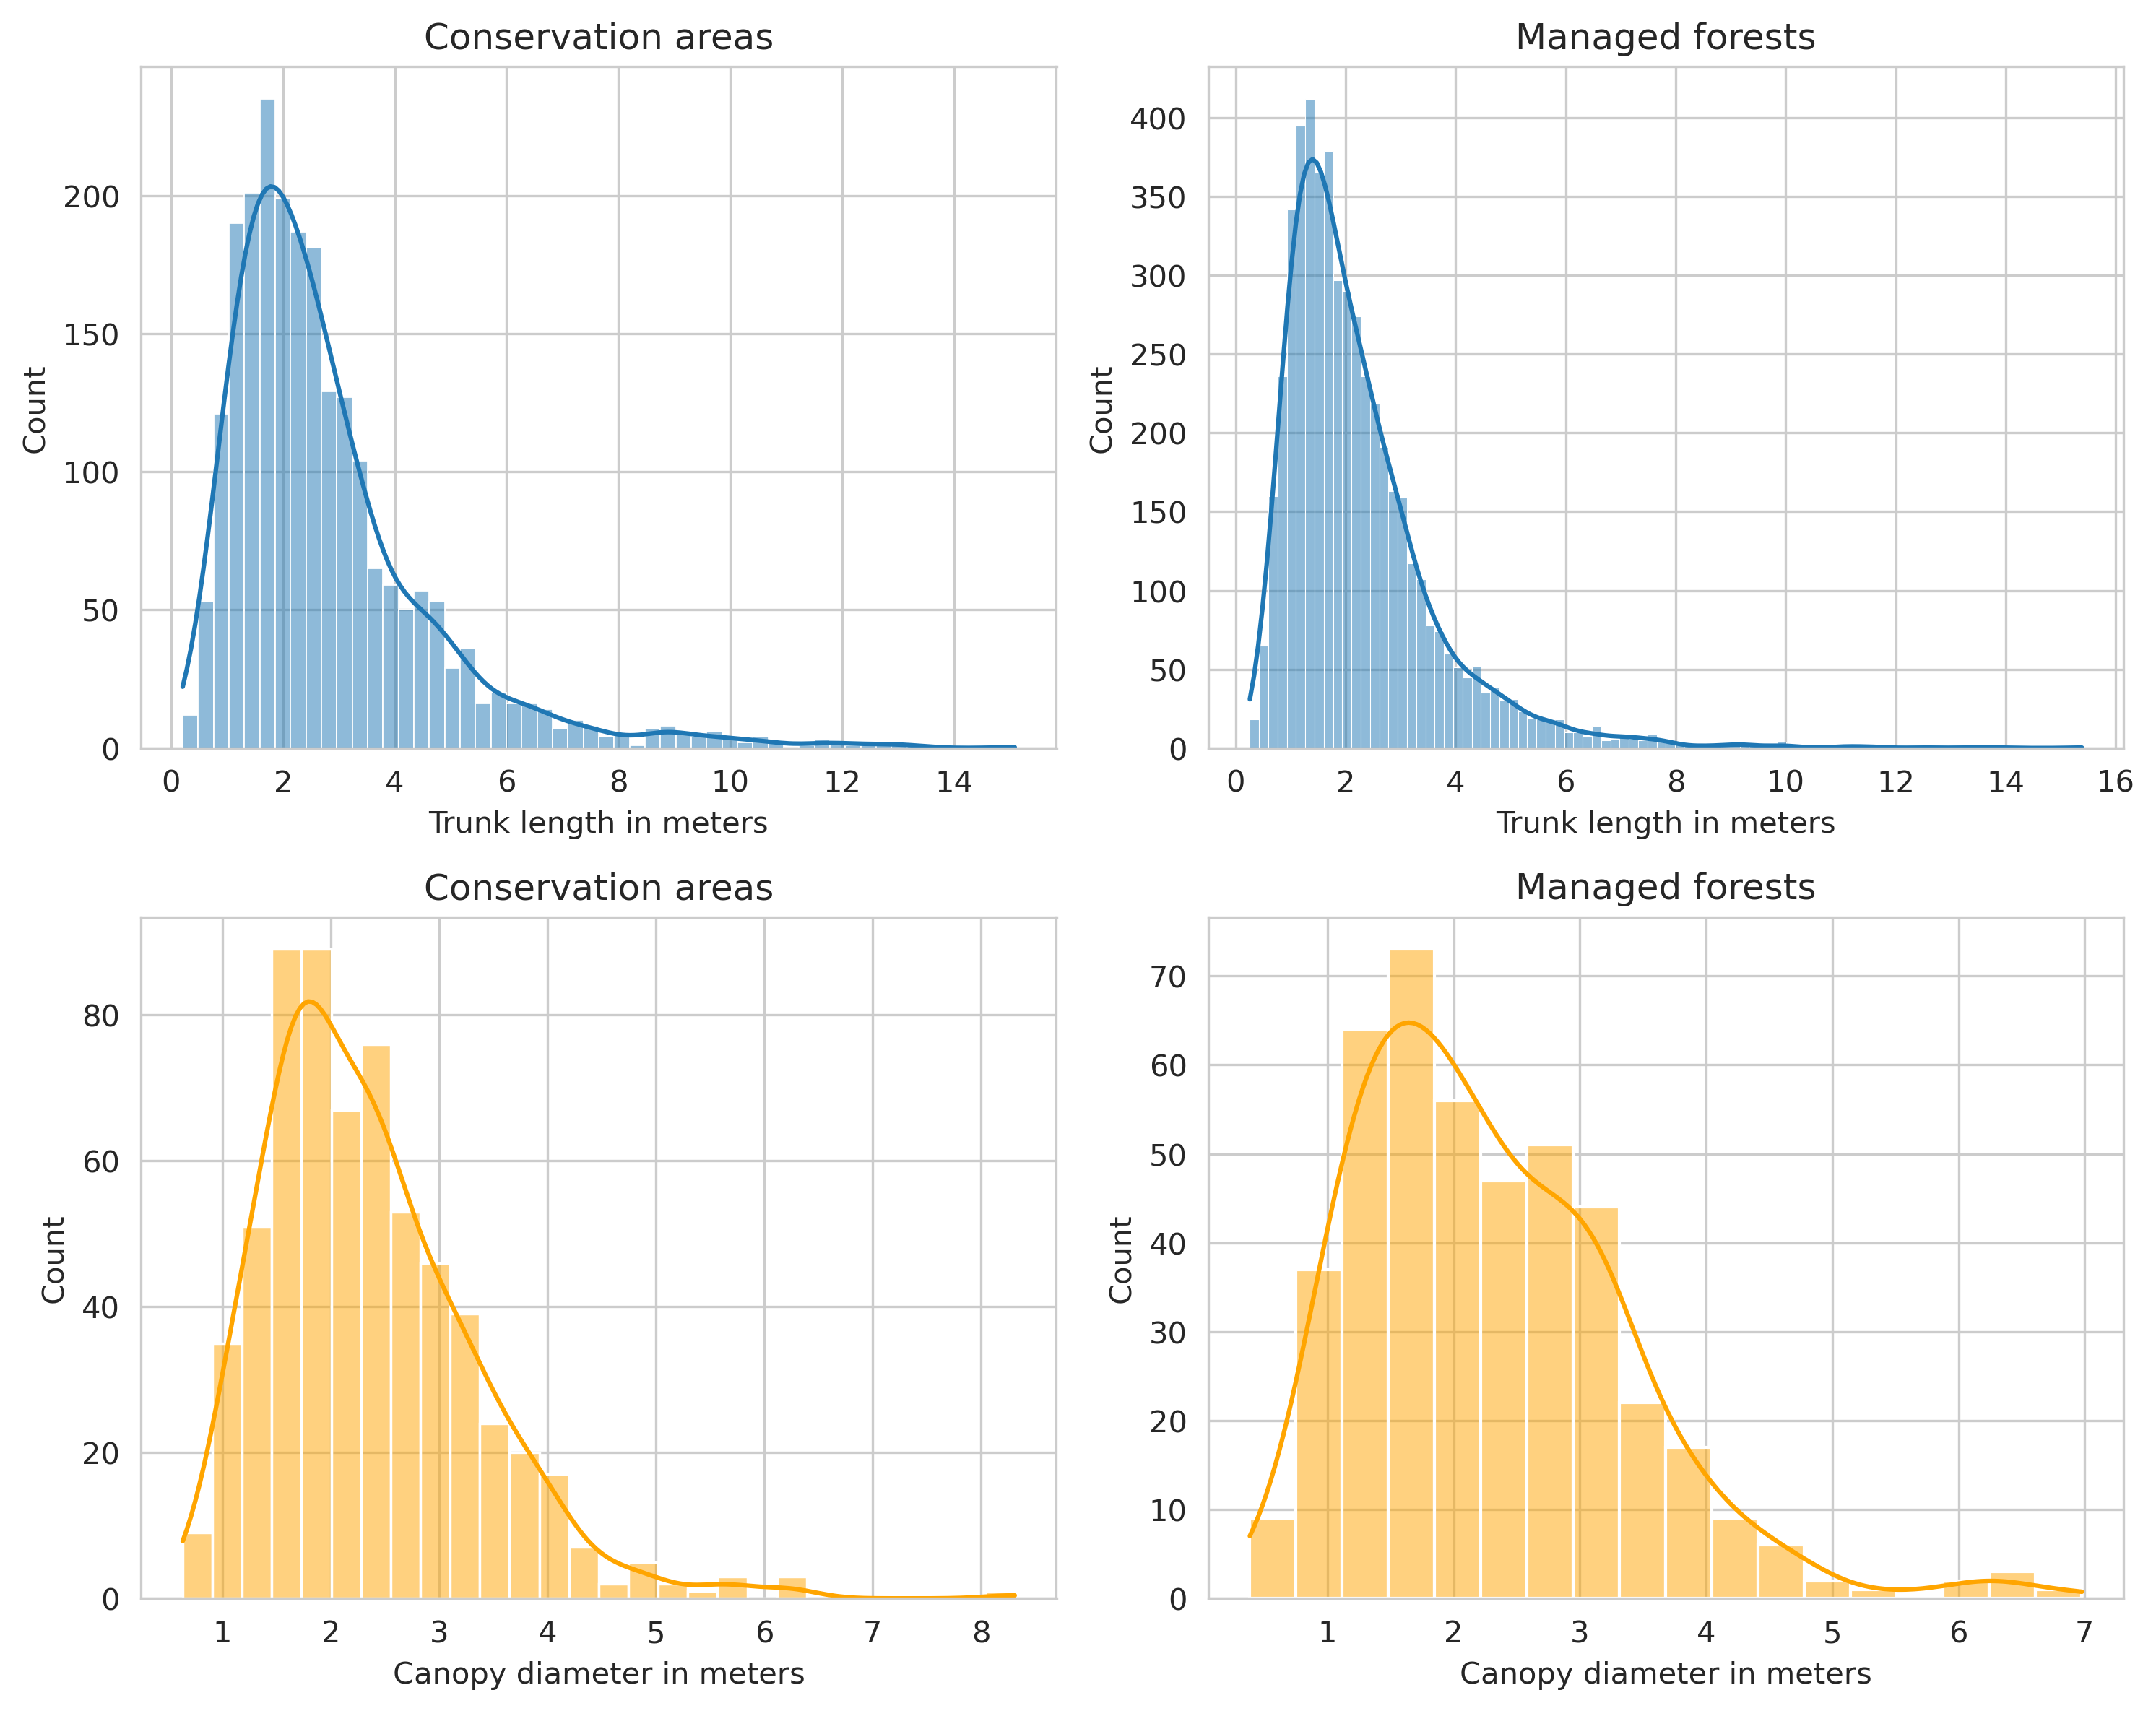

In [13]:
fig, ax = plt.subplots(2,2, figsize=(10,8), dpi=300, sharey=False)
sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,0])
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Trunk length in meters')
sns.histplot(full_data[(full_data.layer=='groundwood') & (full_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,1])
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Trunk length in meters')

sns.histplot(full_data[(full_data.layer=='uprightwood') & (full_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,0], color='orange')
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Canopy diameter in meters')
sns.histplot(full_data[(full_data.layer=='uprightwood') & (full_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,1], color='orange')
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Canopy diameter in meters')
plt.tight_layout()

### Evo dataset

We constructed the virtual plots from Evo area as 100x100 meter non-overlapping squares in such way that each virtual plot contained only one circular field plot. This dataset contained 3915 fallen deadwood and 1419 stanind deadwood instances, and the total number of deadwood instances in a single field plot varied between 3 and 570, the number of fallen deadwood between 1 and 570, and the number of standing deadwood between 1 and 162. The total area covered by fallen deadwood was 3117.1m² and the total canopy area for standing deadwood was 7196.4m². On average, a single deadwood instance covered more area compared to Hiidenportti dataset, as the average area for fallen deadwood in Evo was 0.81m² and 5.08m² for standing deadwood. Similar observations were found from the average tree length and canopy diameter, as the average trunk length of the fallen trees was around 1 meter more in Evo, and canopy diameter of standing trees was around 60cm larger. However, this is likely due to the vast majority of the annotated trees in Evo dataset being in conserved areas.

In [14]:
evo_data = gpd.read_file('../../data/raw/sudenpesankangas/virtual_plots/sudenpesankangas_deadwood.geojson')

In [15]:
pd.crosstab(evo_data.conservation, evo_data.label, margins=True)

label,groundwood,uprightwood,All
conservation,,,
0,569,61,630
1,3346,1358,4704
All,3915,1419,5334


In [16]:
evo_data['area'] = evo_data.geometry.area
evo_data['pixel_area'] = evo_data.area / 0.0485**2
evo_data_dis = evo_data.dissolve(by='label')
evo_data_dis.area

label
groundwood     3117.087445
uprightwood    7196.352919
dtype: float64

In [17]:
pd.pivot_table(evo_data, index=['conservation','label'], values='area', 
               aggfunc=['min', 'max', 'mean', 'median'], margins=True)

min        max      mean    median
                              area       area      area      area
conservation label                                               
0            groundwood   0.089312   3.985097  0.570915  0.437592
             uprightwood  0.496971  22.247491  3.607135  2.597761
1            groundwood   0.064145   8.456464  0.845582  0.583725
             uprightwood  0.319265  41.339628  5.151703  3.507984
All                       0.064145  41.339628  1.944172  0.758211

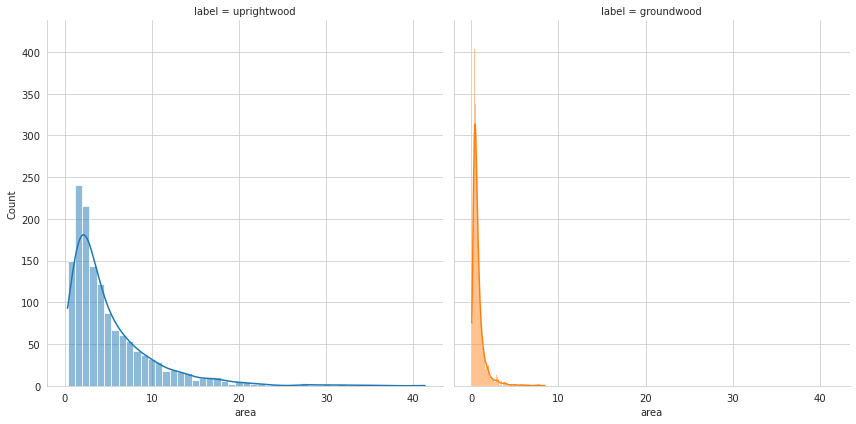

In [18]:
g = sns.FacetGrid(evo_data, col='label', height=6, hue='label')
g.map(sns.histplot, 'area', kde=True, stat='count')

In [19]:
evo_data['tree_length'] = evo_data.apply(lambda row: get_len(row.geometry), axis=1)

In [20]:
pd.pivot_table(evo_data, index=['conservation','label'], 
               values=['tree_length'], aggfunc=['min', 'max', 'mean', 'median', 'count'], margins=True)

min         max        mean      median  \
                         tree_length tree_length tree_length tree_length   
conservation label                                                         
0            groundwood     0.605847   11.732769    2.810096    2.364456   
             uprightwood    0.820098    6.176747    2.507922    2.361254   
1            groundwood     0.575351   24.479043    3.534998    2.865787   
             uprightwood    0.674329    8.319080    2.978771    2.762480   
All                         0.575351   24.479043    3.304312    2.779696   

                               count  
                         tree_length  
conservation label                    
0            groundwood          569  
             uprightwood          61  
1            groundwood         3346  
             uprightwood        1358  
All                             5334

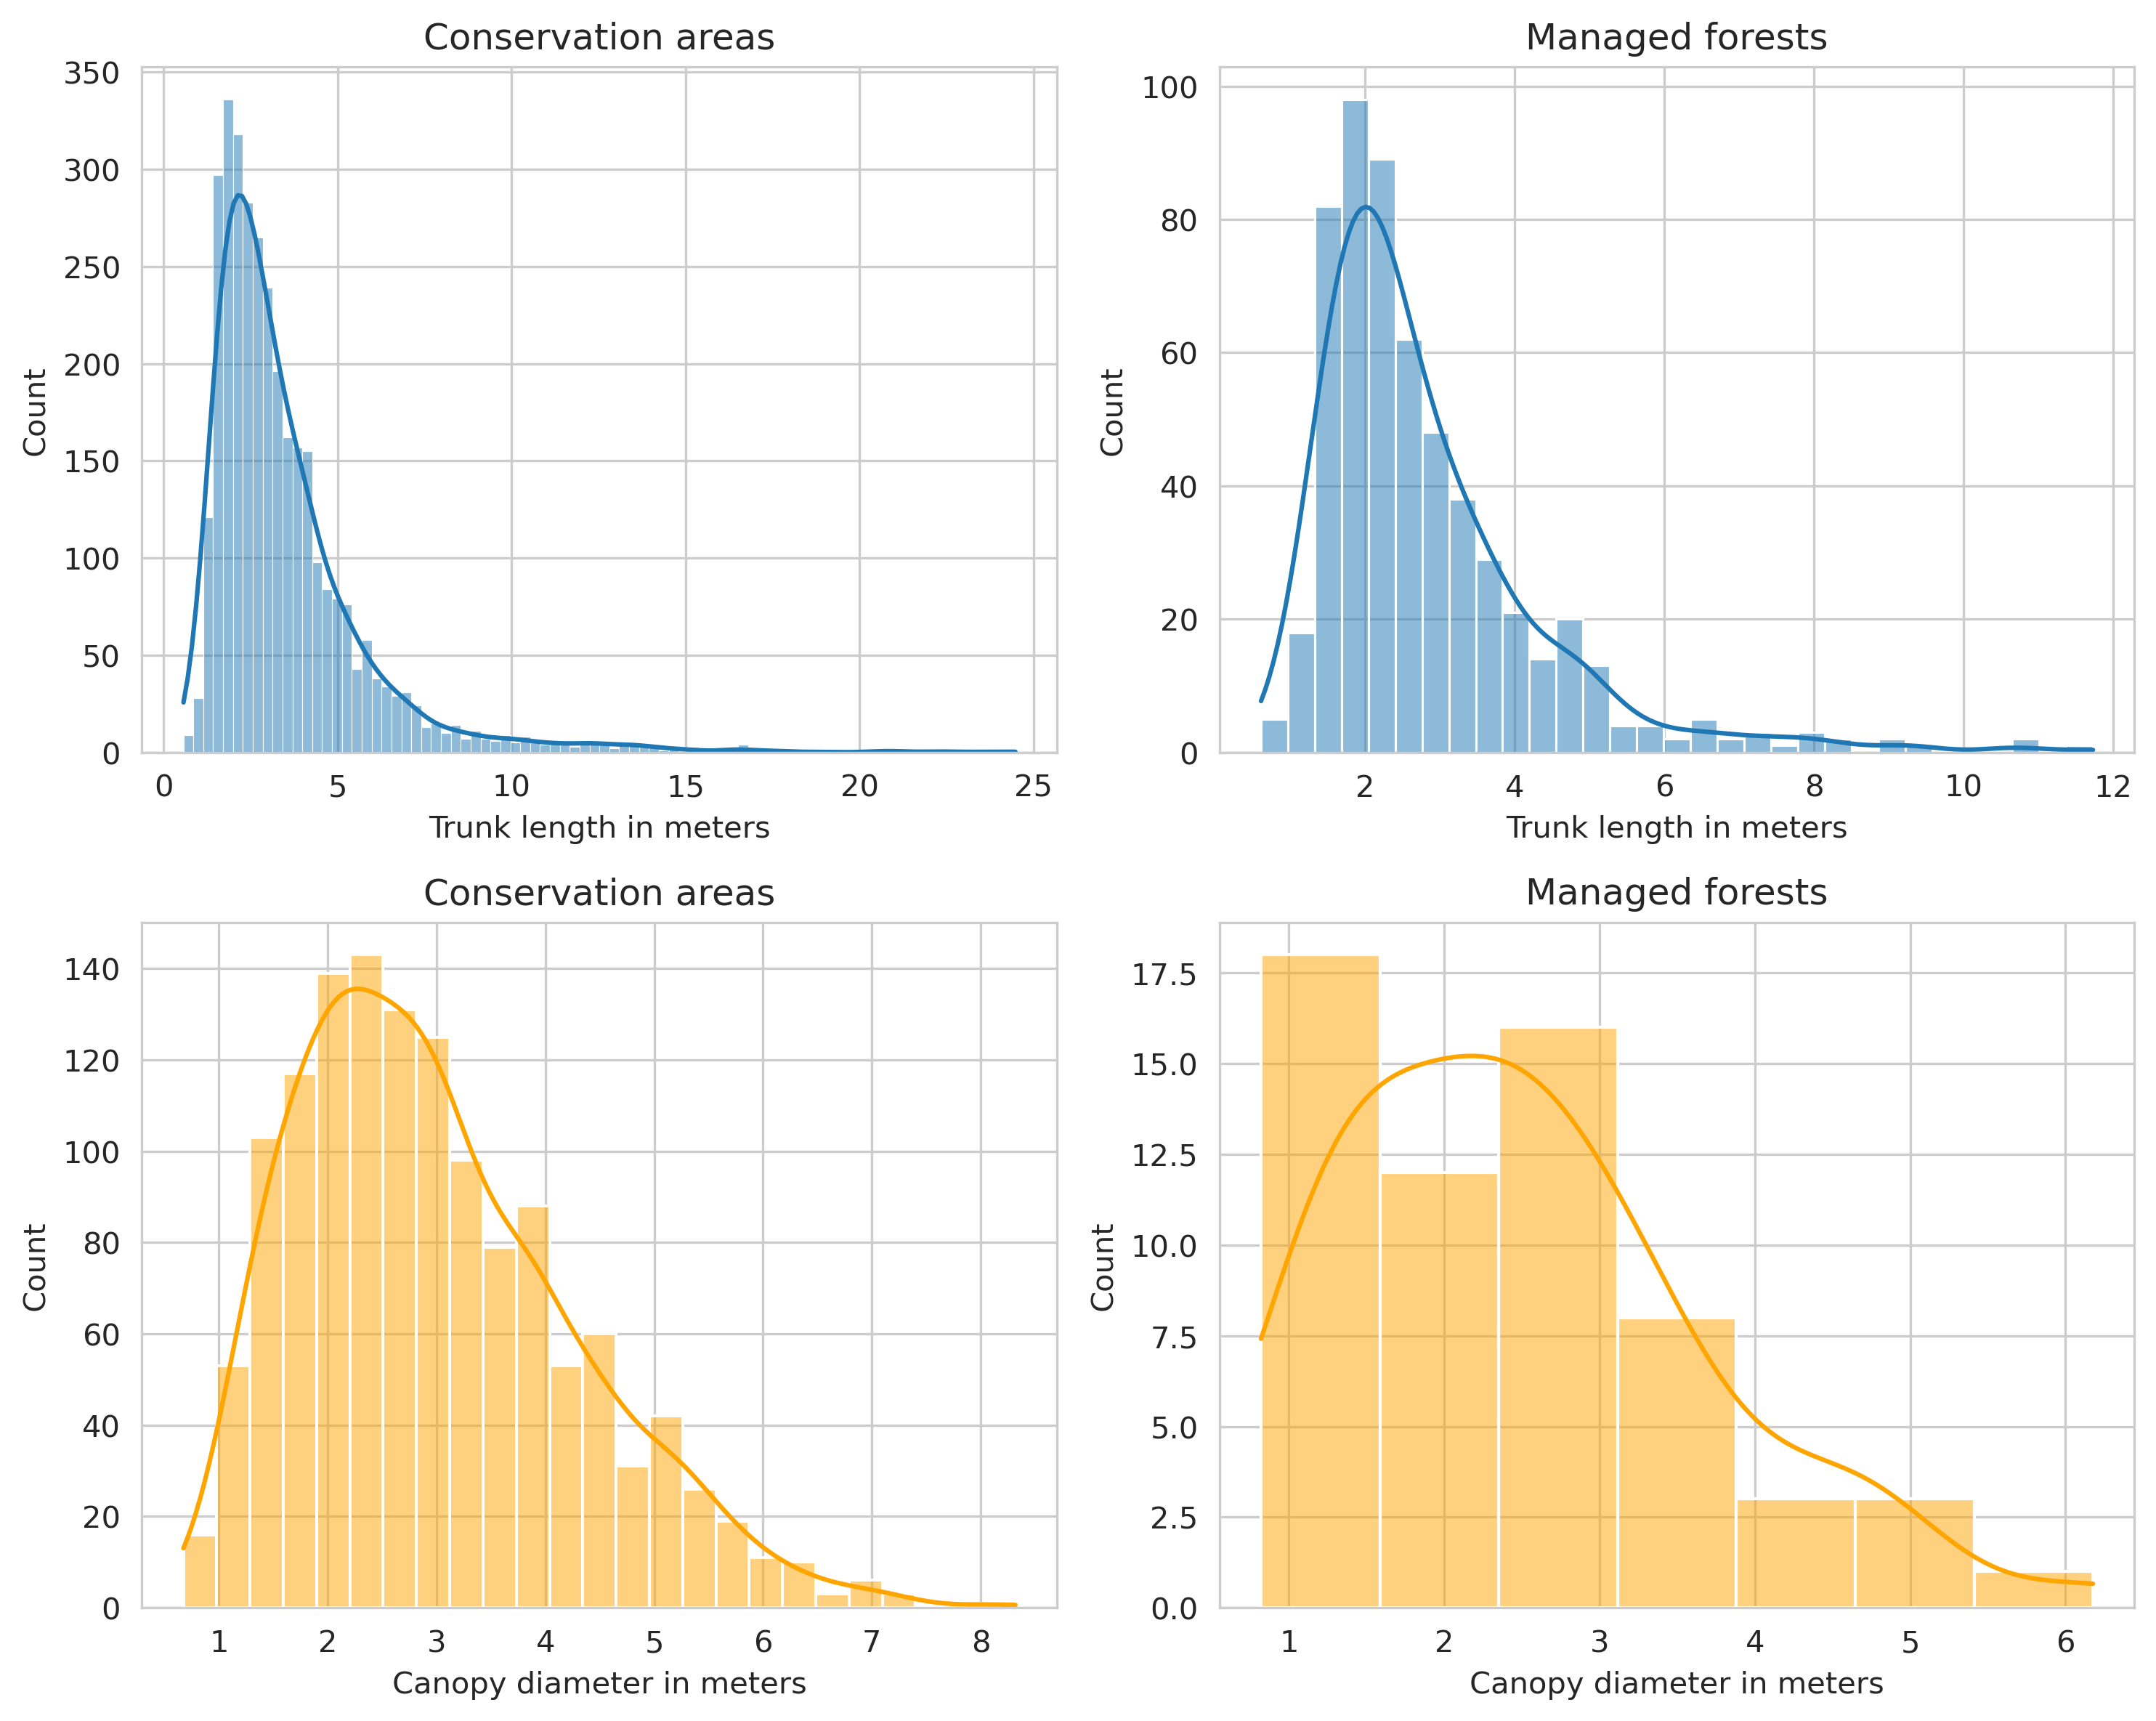

In [21]:
fig, ax = plt.subplots(2,2, figsize=(10,8), dpi=300, sharey=False)
sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,0])
ax[0,0].set_title('Conservation areas')
ax[0,0].set_xlabel('Trunk length in meters')
sns.histplot(evo_data[(evo_data.label=='groundwood') & (evo_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[0,1])
ax[0,1].set_title('Managed forests')
ax[0,1].set_xlabel('Trunk length in meters')

sns.histplot(evo_data[(evo_data.label=='uprightwood') & (evo_data.conservation == 1)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,0], color='orange')
ax[1,0].set_title('Conservation areas')
ax[1,0].set_xlabel('Canopy diameter in meters')
sns.histplot(evo_data[(evo_data.label=='uprightwood') & (evo_data.conservation == 0)], 
             x='tree_length', kde=True, stat='count', ax=ax[1,1], color='orange')
ax[1,1].set_title('Managed forests')
ax[1,1].set_xlabel('Canopy diameter in meters')
plt.tight_layout()

### Training data generation

In order to ensure that no training data leaked into the test set, which would have given our models overly optimistic results, we selected 5 of the virtual plots as the holdout set to test our models. These virtual plots contained both managed and conserved areas, and were only used for testing the models. Furthermore, the remaining 28 plots were spatially split to training and validation sets with 85:15 ratio to ensure that the models were validated during training with data not used for training.

As our virtual plots had too large dimensions to be efficiently used as the training data for the deep learning models, the final preprocessing step for UAV plot images was to split each of them into 512 times 512 pixel image patches. We also split the the polygon data into separate files so that each file only covers this smaller area. Finally, we converted the polygon data into COCO format, in which the polygon coordinates are converted into pixel coordinates related to the corresponding image. Because mosaicking images this way meant that some of the annotated polygons were only partially present in image patches, we removed all partial annotations whose area was less than 25% of the original annotation. Also, all polygons that had bounding box smaller than 16 pixels were discarded, as that small targets can not be accurately found from the data. For test images, as the model outputs were in COCO format, the results were transformed into georeferenced polygon data.

#### Hiidenportti train

In [22]:
tile_folder = Path('../../data/raw/hiidenportti/virtual_plots/train/images/')
vector_folder = Path('../../data/raw/hiidenportti/virtual_plots/train/vectors/')

outpath = Path('../../data/processed/hiidenportti/train_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [24]:
import shapely
from shapely.geometry import box
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf.rename(columns={'groundwood':'label'}, inplace=True)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf['label'] = gdf.apply(lambda row: 'Standing' if row.label == 1 else 'Fallen', axis=1)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Train dataset for deadwood detection in Hiidenportti',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('layer')

In [28]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'hiidenportti_train.json', 'w') as outfile: json.dump(full_coco, outfile)

#### Hiidenportti valid

In [31]:
tile_folder = Path('../../data/raw/hiidenportti/virtual_plots/valid/images/')
vector_folder = Path('../../data/raw/hiidenportti/virtual_plots/valid/vectors/')

outpath = Path('../../data/processed/hiidenportti/valid_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [33]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf.rename(columns={'groundwood':'label'}, inplace=True)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf['label'] = gdf.apply(lambda row: 'Standing' if row.label == 1 else 'Fallen', axis=1)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Validation dataset for deadwood detection in Hiidenportti',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('layer')

In [35]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'hiidenportti_valid.json', 'w') as outfile: json.dump(full_coco, outfile)

#### Hiidenportti test

In [40]:
tile_folder = Path('../../data/raw/hiidenportti/virtual_plots/test/images/')
vector_folder = Path('../../data/raw/hiidenportti/virtual_plots/test/vectors/')

outpath = Path('../../data/processed/hiidenportti/test_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [42]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf.rename(columns={'groundwood':'label'}, inplace=True)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf['label'] = gdf.apply(lambda row: 'Standing' if row.label == 1 else 'Fallen', axis=1)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Test dataset for deadwood detection in Hiidenportti',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('layer')

In [44]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'hiidenportti_test.json', 'w') as outfile: json.dump(full_coco, outfile)

#### Sudenpesänkangas train

In [65]:
tile_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/train/images/')
vector_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/train/vectors/')

outpath = Path('../../data/processed/sudenpesankangas/train_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [67]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Train dataset for deadwood detection in Sudenpesänkangas',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('label')

In [69]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'sudenpesankangas_train.json', 'w') as outfile: json.dump(full_coco, outfile)

#### Sudenpesänkangas valid

In [55]:
tile_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/valid/images/')
vector_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/valid/vectors/')

outpath = Path('../../data/processed/sudenpesankangas/valid_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [57]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Train dataset for deadwood detection in Sudenpesänkangas',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('label')

In [59]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'sudenpesankangas_valid.json', 'w') as outfile: json.dump(full_coco, outfile)

#### Sudenpesänkangas test

In [60]:
tile_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/test/images/')
vector_folder = Path('../../data/raw/sudenpesankangas/virtual_plots/test/vectors/')

outpath = Path('../../data/processed/sudenpesankangas/test_512')

tiles = os.listdir(tile_folder)
vectors = [f for f in os.listdir(vector_folder) if f.endswith('geojson')]
assert len(tiles) == len(vectors)

In [ ]:
for t in tiles:
    if not os.path.exists(outpath/t[:-4]): os.makedirs(outpath/t[:-4])
    shp_fname = t.replace('tif', 'geojson')
    tilesize = 512
    tiler = Tiler(outpath=outpath/t[:-4], gridsize_x=tilesize, gridsize_y=tilesize, overlap=(0,0))
    tiler.tile_raster(str(tile_folder/t))
    tiler.tile_vector(vector_folder/shp_fname, min_area_pct=0.25)

In [62]:
#Fix labelling, todo fix it in COCOProcessor

for p in os.listdir(outpath):
    files = [outpath/p/'vector_tiles'/f for f in os.listdir(outpath/p/'vector_tiles') if f.endswith('geojson')]
    for f in files: 
        gdf = gpd.read_file(f)
        bbox = box(*gdf.total_bounds)
        gdf['geometry'] = gdf.geometry.buffer(0) # fix faulty geometries
        gdf['geometry'] = gdf.apply(lambda row: fix_multipolys(row.geometry) if row.geometry.type == 'MultiPolygon' 
                                    else shapely.geometry.Polygon(row.geometry.exterior), axis=1)
        gdf = gpd.clip(gdf, bbox, keep_geom_type=True)
        gdf.to_file(f, driver='GeoJSON')

In [ ]:
# Convert to COCO format

from drone_detector.processing.coco import *

deadwood_categories = [
        {'supercategory':'deadwood', 'id':1, 'name': 'uprightwood'},
        {'supercategory':'deadwood', 'id':2, 'name': 'groundwood'},
    ]

from datetime import date

coco_info = {'description': 'Test dataset for deadwood detection in Sudenpesänkangas',
             'version': 0.1,
             'year': 2022,
             'contributor': 'Janne Mäyrä',
             'date_created': date.today().strftime("%Y/%m/%d")
}

coco_licenses = {}

for p in os.listdir(outpath):
    coco_processor = COCOProcessor(outpath/p, outpath/p, coco_info=coco_info, coco_licenses=coco_licenses,
                                  coco_categories=deadwood_categories)
    coco_processor.shp_to_coco('label')

In [64]:
# Combine several coco-annotation .json files into one

import json

full_coco = None
image_id_modifier = 0
ann_id_modifier = 0
for p in os.listdir(outpath):
    with open(outpath/p/'coco.json') as f:
        coco = json.load(f)
    
    # update filename
    for i in coco['images']:
        i['file_name'] = f"{p}/raster_tiles/{i['file_name']}"
        
    if full_coco is None: 
        full_coco = coco
        image_id_modifier = full_coco['images'][-1]['id']
        ann_id_modifier = full_coco['annotations'][-1]['id']
    else:
        for i in coco['images']:
            i['id'] += image_id_modifier
        for a in coco['annotations']:
            a['image_id'] += image_id_modifier
            a['id'] += ann_id_modifier
        
        full_coco['images'].extend(coco['images'])
        full_coco['annotations'].extend(coco['annotations'])
        image_id_modifier = full_coco['images'][-1]['id'] + 1
        ann_id_modifier = full_coco['annotations'][-1]['id'] + 1
        
with open(outpath.parents[0]/'sudenpesankangas_test.json', 'w') as outfile: json.dump(full_coco, outfile)